<a href="https://colab.research.google.com/github/hajrajaa/HSTS/blob/master/HW-1/HW1_322512690_21239353_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 - Deep Learning Winter 2024

Student 1: Rajaa Haj 322512690

Student 2: Aseel Shaheen 212393532



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#**Part 1 : Binary Classification**

#Loading the Data

In [ ]:
import pandas as pd

# Define the paths to your datasets
train_path = '/content/drive/MyDrive/HW-1/part1_train.csv'
test_path = '/content/drive/MyDrive/HW-1/part1_test.csv'

# Load the datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Display the 10 samples fron the datasets
print("samples from the Training Data:\n")
print(train_data.head(n=10))
print("\n")
print("Samples from the Test Data:\n")
print(test_data.head(n=10))


#**Preprocessing the data :**
In order to scale the data we need first to covnert non-numerical values into numerical represtnation. so what we do is we apply one-hot encoding in order to represnt them.

In [ ]:

# Identify categorical columns that exist in both train and test datasets
categorical_columns = list(set(train_data.select_dtypes(include=['object']).columns) &
                           set(test_data.select_dtypes(include=['object']).columns))

# Extract target variable before encoding (assuming last column is the target)
y_train = train_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

#need to remove the '.' in order to make the data clear and now convert it to numerical.
y_test = test_data.iloc[:, -1].str.strip().str.replace('.', '', regex=False)
# Strip whitespace from target column values
y_train = y_train.str.strip()
y_test = y_test.str.strip()


# Define the mapping for target values
label_mapping = {"<=50K": 0, ">50K": 1}

# Apply the mappingt
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)


# Apply one-hot encoding separately (for training and test (without target))
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns)

# Align columns between train and test datasets to handle mismatched categories
train_data_aligned, test_data_aligned = train_data_encoded.align(test_data_encoded, join='inner', axis=1)


52


# **Exctract features and exclude the target for training and test and scaling the data using the StandardScaler.**

In [ ]:

# Extract features (after alignment)
X_train = train_data_aligned.drop(columns=train_data_aligned.columns[-1])  # Drop target column
X_test = test_data_aligned.drop(columns=test_data_aligned.columns[-1])    # Drop target column

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# # Print shapes to verify
# print("X_train_scaled shape:", X_train_scaled.shape)
# print("X_test_scaled shape:", X_test_scaled.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)


In [ ]:
# Convert data to PyTorch tensors

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

Now we Print the distribution of yearly income for the individuals and the
percentage of them more / less than 50k/year

In [ ]:
# Compute distribution for y_train
unique, counts = torch.unique(y_train, return_counts=True)

# Print the distribution
print("Income Distribution in Training Data:")
for value, count in zip(unique, counts):
    label = "<=50K" if value.item() == 0 else ">50K"
    print(f"{label}: {count.item()}")

# Compute percentages
total = counts.sum().item()
percentages = (counts.float() / total) * 100

# Print the percentages
print("\nIncome Percentage in Training Data:")
for value, percent in zip(unique, percentages):
    label = "<=50K" if value.item() == 0 else ">50K"
    print(f"{label}: {percent.item():.2f}%")


Income Distribution in Training Data:
<=50K: 24719
>50K: 7841

Income Percentage in Training Data:
<=50K: 75.92%
>50K: 24.08%


# Define the model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Hidden layer 1
        self.dropout1 = nn.Dropout(p=0.2)    # Dropout for regularization
        self.fc2 = nn.Linear(64, 32)         # Hidden layer 2
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(32, 2)          # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function for first layer
        x = F.relu(self.fc2(x))  # Activation function for second layer
        x = self.fc3(x)          # No activation for output layer (raw scores)
        return x


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Input size is the number of features (but its gone to 51 due to one-code being applied which increased it)
input_size = X_train.shape[1]

# Define the model and hyperamreters
model = FeedForwardNN(input_size)
learning_rate = 0.01
epochs = 20
batch_size = 32


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
#we make each epoch to go on the batch size and not the entire data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predictions = torch.max(test_outputs, 1)

accuracy = (test_predictions == y_test).sum().item() / y_test.size(0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")




Epoch 1/20, Loss: 0.4348
Epoch 2/20, Loss: 0.4259
Epoch 3/20, Loss: 0.4256
Epoch 4/20, Loss: 0.4232
Epoch 5/20, Loss: 0.4221
Epoch 6/20, Loss: 0.4212
Epoch 7/20, Loss: 0.4223
Epoch 8/20, Loss: 0.4234
Epoch 9/20, Loss: 0.4225
Epoch 10/20, Loss: 0.4216
Epoch 11/20, Loss: 0.4214
Epoch 12/20, Loss: 0.4202
Epoch 13/20, Loss: 0.4202
Epoch 14/20, Loss: 0.4219
Epoch 15/20, Loss: 0.4200
Epoch 16/20, Loss: 0.4196
Epoch 17/20, Loss: 0.4193
Epoch 18/20, Loss: 0.4204
Epoch 19/20, Loss: 0.4197
Epoch 20/20, Loss: 0.4186
Test Accuracy: 80.15%


# **Part 2 : Multi Class Classification**

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

Downloading the data and spliting the training and test

In [ ]:
# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download and load the FashionMNIST dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 227kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.69MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



**We will Create the Batch sizes in this Cell.**

In [ ]:
# Create data loaders

from torch.utils.data import Subset

def filter_dataset(dataset, allowed_labels):
    indices = [i for i, (_, label) in enumerate(dataset) if label in allowed_labels]
    return Subset(dataset, indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# Filter training and validation datasets for Network 1 (first 4 categories)
allowed_labels = [0, 1, 2, 3]
train_dataset_1 = filter_dataset(train_dataset, allowed_labels)
val_dataset_1 = filter_dataset(val_dataset, allowed_labels)
test_dataset_1 = filter_dataset(test_data, allowed_labels)

# Create DataLoaders for Network 1
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=batch_size, shuffle=False)
test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)






#**Define the Model:**

# The first feed forward netwoek : Netwrok 1
Creating the First NN1. Since its parameters shouldnt pass 50k, our network will be : <br>
input size= 784 since flatteing (28X28) img to vector to output 60. <br>
parameters for  first layer is : input (60) and output 4 .<br>
 which the Total parameters will be (784X60)+ 60 (bias) + (60X4) + 4 (bias)  <=50k

In [ ]:

class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1 = nn.Linear(784, 60)  # First layer: 784 → 60
        self.fc2 = nn.Linear(60, 4)   # Second layer: 60 → 4

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 28x28 images into 1D vector
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output
        return x


# The secound feed forward Network : Network 2

Defining NN2   Since its parameters shouldnt pass 60k, our network will be :
input size= 784 since flatteing (28X28) img to vector to output (80):.
parameters for first layer is : input (80) and output (40) .<br>
second Layer: input (40) to output (20)
third Layer : input (20) to output (10) .
which the Total parameters will be 62,720+3,240+820+210=66,990

In [ ]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1 = nn.Linear(784, 60)  # First layer: 784 → 80
        self.fc2 = nn.Linear(60, 40)  # Second layer: 80 → 40
        self.fc3 = nn.Linear(40, 20)  # Third layer: 40 → 20
        self.fc4 = nn.Linear(20, 10)  # Fourth layer: 20 → 10

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 28x28 images into 1D vector
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Output
        return x


# Training the model:

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    # Store metrics
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]*100:.2f}%, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]*100:.2f}%")

    return train_loss, val_loss, train_acc, val_acc



In [ ]:
# Instantiate models
model1 = Network1()  # Network 1 for 4 categories
model2 = Network2()  # Network 2 for all 10 categories

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)  # With L2 regularization
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

# Training parameters
epochs = 20

# Train both networks
print("Training Network 1:")
train_loss1, val_loss1, train_acc1, val_acc1 = train_model(model1, train_loader_1, val_loader_1, optimizer1, criterion, epochs)

print("\nTraining Network 2:")
train_loss2, val_loss2, train_acc2, val_acc2 = train_model(model2, train_loader, val_loader, optimizer2, criterion, epochs)


Training Network 1:
Epoch 1/20, Train Loss: 0.2772, Train Acc: 90.68%, Val Loss: 0.2380, Val Acc: 91.33%
Epoch 2/20, Train Loss: 0.1937, Train Acc: 93.46%, Val Loss: 0.1903, Val Acc: 93.35%
Epoch 3/20, Train Loss: 0.1767, Train Acc: 93.97%, Val Loss: 0.1853, Val Acc: 93.08%
Epoch 4/20, Train Loss: 0.1597, Train Acc: 94.56%, Val Loss: 0.1650, Val Acc: 94.29%
Epoch 5/20, Train Loss: 0.1482, Train Acc: 94.90%, Val Loss: 0.1573, Val Acc: 94.58%
Epoch 6/20, Train Loss: 0.1444, Train Acc: 95.09%, Val Loss: 0.1557, Val Acc: 94.64%
Epoch 7/20, Train Loss: 0.1303, Train Acc: 95.64%, Val Loss: 0.1511, Val Acc: 94.50%
Epoch 8/20, Train Loss: 0.1203, Train Acc: 95.80%, Val Loss: 0.1493, Val Acc: 94.66%
Epoch 9/20, Train Loss: 0.1139, Train Acc: 96.16%, Val Loss: 0.1584, Val Acc: 94.37%
Epoch 10/20, Train Loss: 0.1063, Train Acc: 96.34%, Val Loss: 0.1512, Val Acc: 94.68%
Epoch 11/20, Train Loss: 0.1037, Train Acc: 96.48%, Val Loss: 0.1518, Val Acc: 94.64%
Epoch 12/20, Train Loss: 0.0955, Train Acc:

# Model evauluation :

In [ ]:
def evaluate_model(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(loader), accuracy



In [ ]:
# Evaluate Network 1
test_loss1, test_acc1 = evaluate_model(model1, test_loader_1, criterion)
print(f"Network 1 - Test Loss: {test_loss1:.4f}, Test Accuracy: {test_acc1 * 100:.2f}%")

# Evaluate Network 2
test_loss2, test_acc2 = evaluate_model(model2, test_loader, criterion)
print(f"Network 2 - Test Loss: {test_loss2:.4f}, Test Accuracy: {test_acc2 * 100:.2f}%")


Network 1 - Test Loss: 0.1995, Test Accuracy: 93.95%
Network 2 - Test Loss: 0.3864, Test Accuracy: 86.95%


# Plot the Losses and Accuracy:

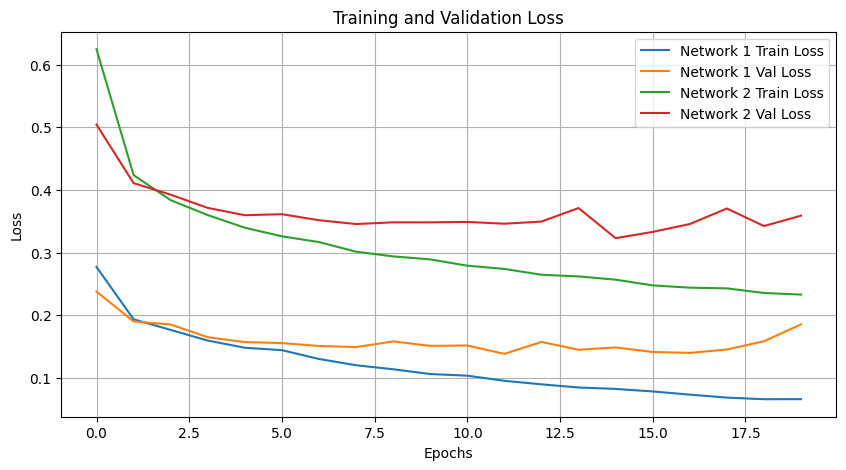

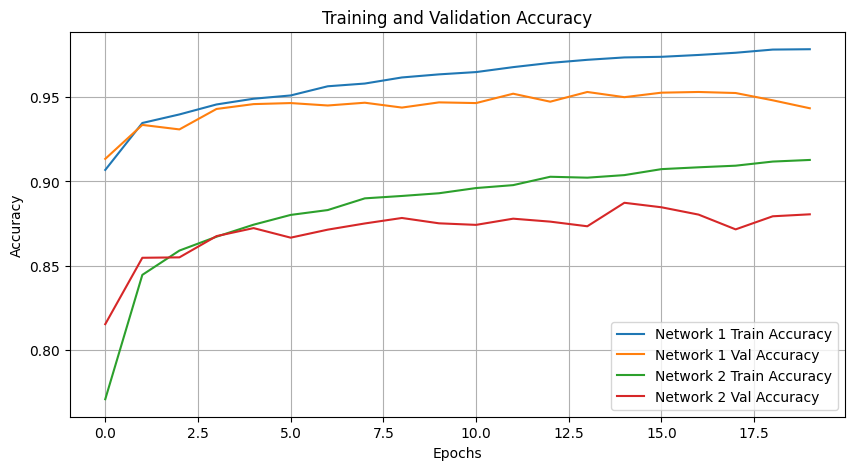

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss1, label='Network 1 Train Loss')
plt.plot(val_loss1, label='Network 1 Val Loss')
plt.plot(train_loss2, label='Network 2 Train Loss')
plt.plot(val_loss2, label='Network 2 Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc1, label='Network 1 Train Accuracy')
plt.plot(val_acc1, label='Network 1 Val Accuracy')
plt.plot(train_acc2, label='Network 2 Train Accuracy')
plt.plot(val_acc2, label='Network 2 Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
